Problem Statement : We have to predict whether a given tweet is about a real disaster or not. - If so, predict a 1. If not, predict a 0.

***NECESSARY LIBRARIES***

In [3]:
#Necessary Libraries

import numpy as np
import pandas as pd

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

***UNDERSTANDING DATA & FILTERING***

In [4]:
#Training data
full_path = '/Users/sanghamitramatta/Documents/All Women Bootcamp/Tweet prediction/Data/tweet_disasters.csv'
train = pd.read_csv(full_path)

print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#To understand the data, checking a row chosen at random. Here 4th row
train.iloc[3].values


array([6, nan, nan,
       '13,000 people receive #wildfires evacuation orders in California ',
       1], dtype=object)

In [6]:
# To check the unique values of the column
train['target'].unique()

array([1, 0])

In [7]:
#Filtering the rows with target value = 1
train[train['target']==1]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [8]:
#To get the row of the Text column where Target column value = 1 
train[train['target']==1]["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

***EDA***

In [10]:
#Missing values
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The columns denote the following:

The text of a tweet.
A keyword from that tweet.
The location the tweet was sent from.

In [11]:
#Missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


***Exploring the Target Variable***

In [12]:
#count of rows grouped by unique values in target
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [13]:
train['target'].value_counts(normalize = True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

In [14]:
#To sort by count
train['target'].value_counts().index

Index([0, 1], dtype='int64', name='target')

In [15]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Target column')

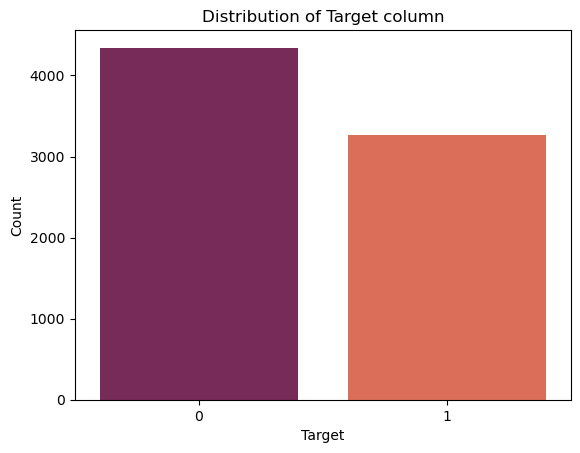

In [16]:
#Visualisation
sns.barplot(x=train['target'].value_counts().index,
            y=train['target'].value_counts().values,
            palette='rocket')
plt.xlabel("Target")
plt.ylabel("Count")
plt.title("Distribution of Target column")

***DISASTER TWEETS***

In [17]:
#Tweets about disaster. print(disaster_tweets) gives df and disaster_tweets.values give the output as an array
disaster_tweets = train[train['target']==1]['text']

disaster_tweets.values

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [18]:
#As a random check
disaster_tweets.values[55]

"@AlexAllTimeLow awwww they're on an airplane accident and they're gonna die what a cuties ???? good job!"

NON DISASTER TWEETS

In [19]:
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values

array(["What's up man?", 'I love fruits', 'Summer is lovely', ...,
       'These boxes are ready to explode! Exploding Kittens finally arrived! gameofkittens #explodingkittens\x89Û_ https://t.co/TFGrAyuDC5',
       'Sirens everywhere!',
       'I just heard a really loud bang and everyone is asleep great'],
      dtype=object)

In [20]:
non_disaster_tweets.values[26]

'I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6'

***EXPLORING THE 'KEYWORD' COLUMN***

In [21]:
train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

<Axes: xlabel='count', ylabel='keyword'>

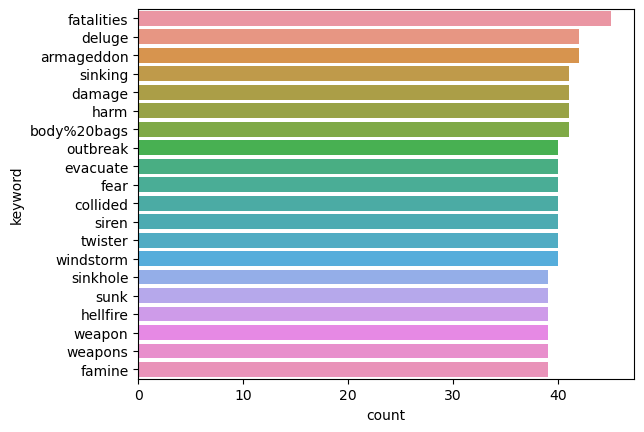

In [22]:
sns.barplot(y= train['keyword'].value_counts()[:20].index,
            x= train['keyword'].value_counts()[:20],
            orient = 'h')

UNDERSTADING HOW MANY ROWS CONTAIN DISASTER

In [23]:
#To get the dataframe with two columns - text and target, with the rows which that contain the word 'disaster'

df = train.loc[train['text'].str.contains('disaster'),['text','target']]

In [24]:
df['target'].value_counts()

target
1    77
0    32
Name: count, dtype: int64

In [25]:
df[df['target']==0]['text'][:3]

2781    I forgot to bring chocolate with me. Major dis...
2783             I'm a disaster?? https://t.co/VCV73BUaCZ
2786    Beautiful disaster // Jon McLaughlin is such a...
Name: text, dtype: object

So, not all the rows that have the word 'disaster' are related to disasters

EXPLORING THE 'LOCATION' COLUMN

In [26]:
train.location.value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [27]:
# standardising the location values
train['location'].replace({"United States":'USA',
                           "London":'UK',
                           "Los Angeles, CA":'USA',
                           "Washington, D.C.":'USA',
                           "Washington, DC":'USA',
                           "California":'USA',
                           "Chicago, IL":'USA',
                           "Chicago":'USA',
                           "New York, NY":'USA',
                           "NY" : 'USA',
                           "California, USA":'USA',
                           "Florida":'USA',
                           "Everywhere":'Worldwide',
                           "San Francisco":'USA',
                           "Florida":'USA',
                           "United Kingdom":'UK',
                           "Los Angeles":'USA',
                           "Toronto":'Canada',
                           "San Francisco, CA":'USA',
                           "NYC":'USA',
                           "Seattle":'USA',
                           "Earth":'Worldwide',
                           "Ireland":'IR',
                           "London, England":'UK',
                           "New York City":'USA',
                           "Texas":'USA',
                           "London, UK":'UK',
                           "Dundee, UK":'UK',
                           "Atlanta, GA":'USA',
                           "Mumbai":"India"},inplace=True)

In [28]:
train['location'].value_counts()[:10]

location
USA          400
UK           107
New York      71
India         46
Worldwide     45
Canada        41
Nigeria       28
Kenya         20
Australia     18
Indonesia     13
Name: count, dtype: int64

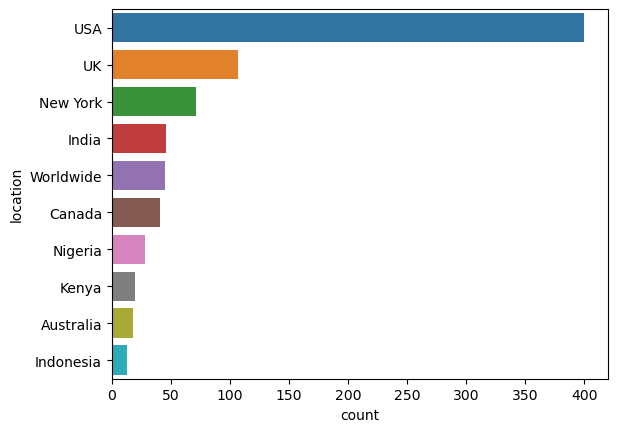

In [30]:
sns.barplot(y=train['location'].value_counts()[:10].index,
            x=train['location'].value_counts()[:10],
            orient='h');

***TEXT DATA PREPROCESSING***

Data Cleaning

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the  basic text pre-processing techniques includes:

Make text all lower case** or uppercase so that the algorithm does not treat the same words in different cases as different
Removing Noise i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values,  common non-sensical text (/n)
Tokenization: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
Stopword Removal: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

More data cleaning steps after tokenization: Stemming and Lemmatizaton. Depending on the necessacity


Approach 1

In [ ]:
#word_tokenize splits a sentence into words and punctuation so your Python code can understand and analyze the text
from nltk.tokenize import word_tokenize 

In [ ]:
#Function to return meaningful words from the text
def clean_tokens(text, language):
    tokens = word_tokenize(text) #Splits the input sentence into individual tokens
    tokens = [w.lower() for w in tokens]#Converts the words into lower case
    stripped = [word for word in tokens if word.isalpha()] #Removes all tokens that contain digits or punctuation.
    stop_words = set(stopwords.words(language)) #Loads stopwords for the given language (e.g., "english").
    words = [w for w in stripped if not w in stop_words] #Removes stopwords from the stripped word list.
    return words

Approach 2

In [39]:
nltk.download('punkt') #Downloads tokenizer rules required by word_tokenize()
nltk.download('stopwords') #Downloads stopword list used in text cleaning

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sanghamitramatta/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanghamitramatta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
# Apply same function as in previous practice

train["text_case1"] = train["text"].apply(lambda x: clean_tokens(x, "english"))

In [41]:
# Applying a first round of text cleaning techniques
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove urls, https
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text) #get rid of digits, ie numbers
    return text

Comparing both the approaches

In [42]:
clean_tokens('I LOVE @NLP_the!!#.www.allwomen.tech is [the best] academy', language='english')

['love', 'best', 'academy']

In [43]:
clean_text('I LOVE @NLP_the!!#.www.allwomen.tech is [the best] academy')

'i love nlpthe is  academy'

Choosing the second approach because sentence like output is used for vectorizing tool like CountVectorizer / TfidfVectorizer in scikit-learn.

***Applying the cleaning function on the training data***

In [45]:
train['text2'] = train['text'].apply(lambda x: clean_text(x))

In [ ]:
#comparing the results of text_case1, text2
train.loc[7610,['text', 'text_case1', 'text2']].values

array(['M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       list(['utc', 'volcano', 'hawaii', 'http']),
       '  s of volcano hawaii '], dtype=object)

In [51]:
print('Raw data in the input file: \n', train['text'].head(3))

print('\nCleansed data from the function: \n', train['text2'].head(3))

Raw data in the input file: 
 0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
Name: text, dtype: object

Cleansed data from the function: 
 0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
Name: text2, dtype: object


In [52]:
#updating disaster_tweets & non_disaster_tweets with the cleansed data
non_disaster_tweets = train[train['target']==0]['text2']
disaster_tweets = train[train['target']==1]['text2']

In [54]:
non_disaster_tweets[70:73]

122    that moment when you get on a scary roller coa...
123          aftershock ã¢  fullã¢ streaming  youtube 
124    gtgt  aftershock  protect yourself and profit ...
Name: text2, dtype: object

In [55]:
disaster_tweets[:3]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
Name: text2, dtype: object

***WORD CLOUD***

In [56]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/fa/5f/34a0c0be52dc95f96aa1197f03ad5d5c58a9901c74f050d21a3e1b21ebf9/wordcloud-1.9.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 1.6 MB/s eta 0:00:00 0:00:01


In [73]:
str(disaster_tweets)

'0       our deeds are the reason of this earthquake ma...\n1                   forest fire near la ronge sask canada\n2       all residents asked to shelter in place are be...\n3        people receive wildfires evacuation orders in...\n4       just got sent this photo from ruby alaska as s...\n                              ...                        \n7608    two giant cranes holding a bridge collapse int...\n7609    ariaahrary thetawniest the out of control wild...\n7610                                 s of volcano hawaii \n7611    police investigating after an ebike collided w...\n7612    the latest more homes razed by northern califo...\nName: text2, Length: 3271, dtype: object'

In [58]:
" ".join(disaster_tweets)

'our deeds are the reason of this earthquake may allah forgive us all forest fire near la ronge sask canada all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected  people receive wildfires evacuation orders in california  just got sent this photo from ruby alaska as smoke from wildfires pours into a school  rockyfire update  california hwy  closed in both directions due to lake county fire  cafire wildfires flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas im on top of the hill and i can see a fire in the woods theres an emergency evacuation happening now in the building across the street im afraid that the tornado is coming to our area three people died from the heat wave so far haha south tampa is getting flooded hah wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding raining flooding florida tampabay tampa  or  days ive lost count

In [74]:
from wordcloud import WordCloud

In [75]:
wordcloud1 = WordCloud(background_color= 'beige',
                       width = 600,
                       height = 400)
wordcloud1.generate(" ".join(disaster_tweets))

In [69]:
wordcloud1

(-0.5, 599.5, 399.5, -0.5)

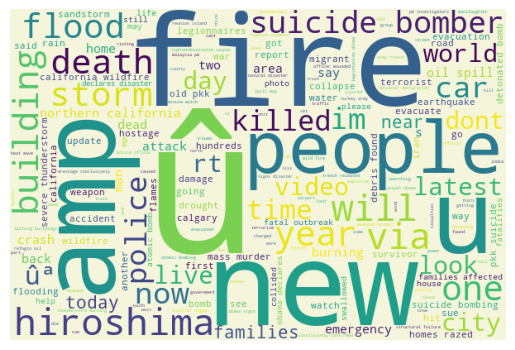

In [76]:
plt.imshow(wordcloud1)
plt.axis('off')

Tokenise the cleaned text text2

In [ ]:
train['text2'] = train['text2'].apply(lambda x: word_tokenize(x))
train['text2'].head(3)

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
Name: text2, dtype: object

In [79]:
train.head(2)

,id,keyword,location,text,target,text_case1,text2
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"


Remove the stopwords

In [80]:
def remove_stopwards(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [81]:
train['text2'] = train['text2'].apply(lambda x: remove_stopwards(x))

In [86]:
train.head(4)

,id,keyword,location,text,target,text_case1,text2
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, place, notified, officers, ...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."


Merging the tokens to form a string

In [87]:
def combine_text(list_of_text):
    combined_text = " ".join(list_of_text)
    return combined_text

In [88]:
train['text2'] = train['text2'].apply(lambda x: combine_text(x))
train.head()

,id,keyword,location,text,target,text_case1,text2
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, place, notified, officers, ...",residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfires pou...


A combined preprocessing function

In [89]:
def text_preprocessing(text, language):
    nopunc = clean_text(text)

    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = tokenizer.tokenize(nopunc)

    remove_stopwords = [w for w in nopunc if w not in stopwords.words(language)]

    combined_text = ' '.join(remove_stopwords)

    return combined_text


In [90]:
train['text_clean'] = train['text'].apply(lambda x : text_preprocessing(x, 'english'))

In [91]:
train.head(2)

,id,keyword,location,text,target,text_case1,text2,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,forest fire near la ronge sask canada


In [94]:
from nltk.corpus import stopwords

In [95]:
stop_words = set(stopwords.words('english'))

In [96]:
stop_words.update(["û", "u","dont", "im", "one", "amp", "new"])

In [99]:
list_words = ["û", "u","dont", "im", "one", "amp", "new"]

In [100]:
# text preprocessing function
def text_preprocessing_updated(text, list_words):
    """
    Cleaning and parsing the text.
    """
  # 1. Data cleaning on the text variable
    nopunc = clean_text(text)

    # 2. Tokenize the cleaned_text
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    # 3. Remove punctuations and stopwords
    nopunc = tokenizer.tokenize(nopunc)

    # 4. Update the stop_words
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(list_words)


    remove_stopwords = [w for w in nopunc if w not in stop_words]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [101]:
train['text3'] = train['text'].apply(lambda x : text_preprocessing_updated(x, list_words) )

In [102]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text3']

# A non-disaster tweet
non_disaster_tweets = train[train['target']==0]['text3']

In [103]:
wordcloud1 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40)

Text(0.5, 1.0, 'Disaster Tweets')

(-0.5, 599.5, 399.5, -0.5)

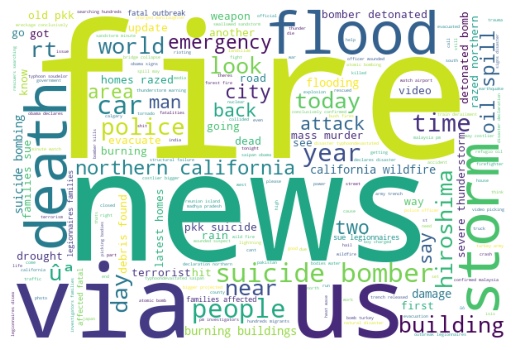

In [105]:
plt.imshow(wordcloud1)
plt.axis('off')

***Transforming tokens to a vector***

Bag of words - to transform text into a meaningful vector (or array) of numbers. We are using Countvectorizer from Scikit learn

In [106]:
count_vectorizer = CountVectorizer(max_features = 1500)

train_vectors = count_vectorizer.fit_transform(train['text3'])

train_vectors

<7613x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 39005 stored elements in Compressed Sparse Row format>

In [108]:
train.shape

(7613, 9)

In [111]:
train_vectors.toarray()[2]

array([0, 0, 0, ..., 0, 0, 0])

TFIDF Features

A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF 

In [113]:
tfidf = TfidfVectorizer(max_features=1500)

In [114]:
tfidf = TfidfVectorizer(max_features=1500,
                        min_df=2, max_df=0.5,ngram_range=(1,2))

train_tfidf = tfidf.fit_transform(train['text3'])

train_tfidf

<7613x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 41342 stored elements in Compressed Sparse Row format>

In [116]:
train_tfidf.toarray()[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [117]:
train_tfidf.shape

(7613, 1500)

In [118]:
y=train['target']

Model - Using Logistic regression to classify the tweets

In [119]:
model = LogisticRegression(max_iter=1000)
model.fit(train_tfidf,y)

LogisticRegression(max_iter=1000)

In [120]:
#Test Data
full_path = '/Users/sanghamitramatta/Documents/All Women Bootcamp/Tweet prediction/Data/tweet_disasters_pred.csv'
test = pd.read_csv(full_path)

print('Training data shape: ', test.shape)
test.head()

Training data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Transforming Test data using text preprocessing function used for the training data

In [121]:
test['text_clean'] = test['text'].apply(lambda x: text_preprocessing(x, 'english'))

In [125]:
#Vectorization
count_vectorizer = CountVectorizer(max_features = 1500)

test_vectors = count_vectorizer.fit_transform(test['text_clean'])

test_vectors

<3263x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 17499 stored elements in Compressed Sparse Row format>

In [127]:
test_vectors.toarray()[10]

array([0, 0, 0, ..., 0, 0, 0])

In [128]:
test_tfidf = tfidf.fit_transform(test['text_clean'])

In [129]:
test_tfidf.shape

(3263, 1500)

In [130]:
X_test_transformed = tfidf.transform(test['text_clean'])
y_pred = model.predict(X_test_transformed)

In [132]:
test['predicted_value'] = y_pred

In [137]:
test.head()

,id,keyword,location,text,text_clean,predicted_value
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,0


***Model Evaluation***

In [136]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
